# Часть 1. Загружаем данные

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

from statsmodels.stats.proportion import proportions_ztest

In [4]:
df = pd.read_csv("data_ab.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [5]:
df.shape

(294478, 5)

In [6]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


# Часть 2. Однородность данных

In [7]:
df['group'].value_counts()

,count
group,
treatment,147276
control,147202


In [8]:
df['landing_page'].value_counts()

,count
landing_page,
old_page,147239
new_page,147239


Изначально планировалось, чтобы выборки были одинаковыми, то есть и группа control, и группа treatment была по 147239

Однако, мы видим, что группы не равномерны, получается, что не все пользователи были определены в верные группы



---

Посмотрим, как примерно идет распредление по дням

Для начала переведем в соответствующий тип данных признак timestamp

In [9]:
df["timestamp"] = pd.to_datetime(df["timestamp"]) # в 22:58:14.991443 хуйня после точки это дробная часть секунды, можем ее убрать
# сразу разделим на 2 признака - только дата и только время
df["date"] = df["timestamp"].dt.date
df["time"] = df["timestamp"].dt.strftime("%H:%M:%S")
# и удаляем признак timestamp чтобы не мешал
#df = df.drop("timestamp", axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
 5   date          294478 non-null  object        
 6   time          294478 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 15.7+ MB


In [11]:
df.groupby(['date', 'group']).agg({'user_id': ['count']})

user_id
                       count
date       group            
2025-01-02 control      2894
           treatment    2889
2025-01-03 control      6684
           treatment    6710
2025-01-04 control      6655
           treatment    6629
2025-01-05 control      6538
           treatment    6586
2025-01-06 control      6684
           treatment    6844
2025-01-07 control      6678
           treatment    6703
2025-01-08 control      6769
           treatment    6795
2025-01-09 control      6725
           treatment    6714
2025-01-10 control      6745
           treatment    6778
2025-01-11 control      6787
           treatment    6766
2025-01-12 control      6615
           treatment    6707
2025-01-13 control      6649
           treatment    6589
2025-01-14 control      6635
           treatment    6694
2025-01-15 control      6809
           treatment    6640
2025-01-16 control      6683
           treatment    6644
2025-01-17 control      6691
           treatment    6631
2025-01-18 control      6578
           treatment    6707
2025-01-19 control      6665
           treatment    6628
2025-01-20 control      6626
           treatment    6767
2025-01-21 control      6823
           treatment    6652
2025-01-22 control      6675
           treatment    6748
2025-01-23 control      6783
           treatment    6728
2025-01-24 control      3811
           treatment    3727

В целом в каждый день обе группы совершали примерно одинаковое количество действий

Посмотрим на конверсию до обработки всех ошибок

In [12]:
df.converted.sum()/len(df)

np.float64(0.11965919355605512)

# Часть 3. Ошибки

## Неправильная страница

Теперь проверим сколько пользователей попали не на ту страницу, то есть в группе control пользователям попалась страница old_page и в группе treatment пользователи увидели страницу new_page

In [13]:
df_control_errors = df[(df["group"] == "control") & (df["landing_page"] != "old_page")]
df_control_errors

,user_id,timestamp,group,landing_page,converted,date,time
22,767017,2025-01-12 22:58:14.991443,control,new_page,0,2025-01-12,22:58:14
240,733976,2025-01-11 15:11:16.407599,control,new_page,0,2025-01-11,15:11:16
490,808613,2025-01-10 21:44:01.292755,control,new_page,0,2025-01-10,21:44:01
846,637639,2025-01-11 23:09:52.682329,control,new_page,1,2025-01-11,23:09:52
850,793580,2025-01-08 03:25:33.723712,control,new_page,1,2025-01-08,03:25:33
...,...,...,...,...,...,...,...
293894,741581,2025-01-09 20:49:03.391764,control,new_page,0,2025-01-09,20:49:03
293996,942612,2025-01-08 13:52:28.182648,control,new_page,0,2025-01-08,13:52:28
294200,928506,2025-01-13 21:32:10.491309,control,new_page,0,2025-01-13,21:32:10
294253,886135,2025-01-06 12:49:20.509403,control,new_page,0,2025-01-06,12:49:20


In [14]:
df_treatment_errors = df[(df["group"] == "treatment") & (df["landing_page"] != "new_page")]
df_treatment_errors

,user_id,timestamp,group,landing_page,converted,date,time
308,857184,2025-01-20 07:34:59.832626,treatment,old_page,0,2025-01-20,07:34:59
327,686623,2025-01-09 14:26:40.734775,treatment,old_page,0,2025-01-09,14:26:40
357,856078,2025-01-12 12:29:30.354835,treatment,old_page,0,2025-01-12,12:29:30
685,666385,2025-01-23 08:11:54.823806,treatment,old_page,0,2025-01-23,08:11:54
713,748761,2025-01-10 15:47:44.445196,treatment,old_page,0,2025-01-10,15:47:44
...,...,...,...,...,...,...,...
293773,688144,2025-01-16 20:34:50.450528,treatment,old_page,1,2025-01-16,20:34:50
293817,876037,2025-01-17 16:15:08.957152,treatment,old_page,1,2025-01-17,16:15:08
293917,738357,2025-01-05 15:37:55.729133,treatment,old_page,0,2025-01-05,15:37:55
294014,813406,2025-01-09 06:25:33.223301,treatment,old_page,0,2025-01-09,06:25:33


In [15]:
df_errors = pd.merge(df_control_errors, df_treatment_errors, how="outer")
df_errors

,user_id,timestamp,group,landing_page,converted,date,time
0,630052,2025-01-07 12:25:54.089486,treatment,old_page,1,2025-01-07,12:25:54
1,630126,2025-01-14 13:35:54.778695,treatment,old_page,0,2025-01-14,13:35:54
2,630137,2025-01-22 14:59:22.051308,control,new_page,0,2025-01-22,14:59:22
3,630320,2025-01-12 05:27:37.181803,treatment,old_page,0,2025-01-12,05:27:37
4,630471,2025-01-07 02:14:17.405726,control,new_page,0,2025-01-07,02:14:17
...,...,...,...,...,...,...,...
3888,945627,2025-01-06 00:03:20.474879,control,new_page,1,2025-01-06,00:03:20
3889,945645,2025-01-20 03:09:21.251778,control,new_page,0,2025-01-20,03:09:21
3890,945703,2025-01-08 19:40:51.169351,control,new_page,0,2025-01-08,19:40:51
3891,945797,2025-01-11 03:04:49.433736,control,new_page,1,2025-01-11,03:04:49


In [16]:
len(df_errors['user_id'].unique())

3893

Из получившейся таблицы можно понять, что не все участники групп получили верную версию страницы. Возможно это связано с какой-то ошибкой в конкретный период времени, это можно проверить с помощью графика. Для начала посмотрим распределение по дням

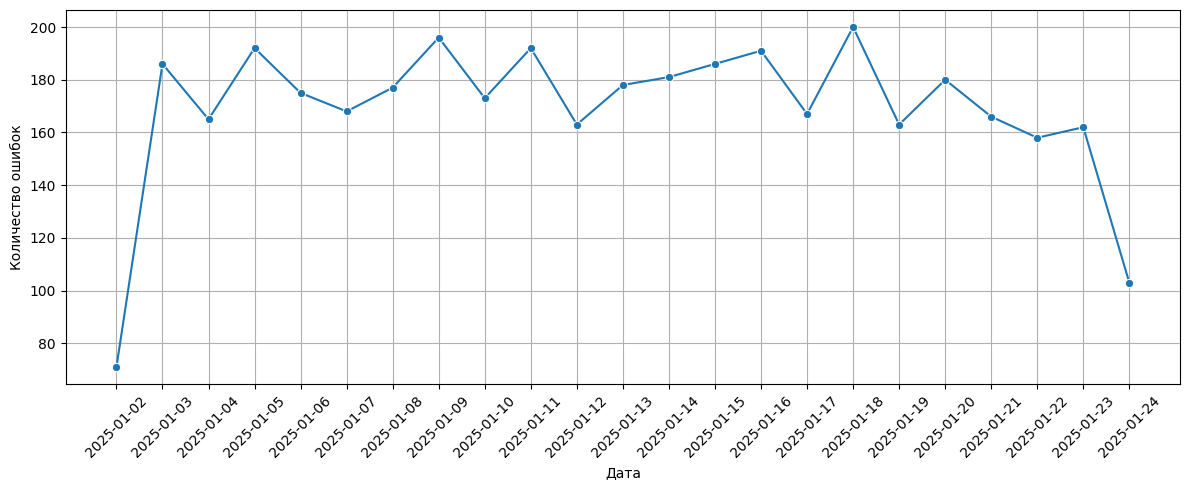

In [17]:
df_errors_grouped = df_errors.groupby("date")["user_id"].count().reset_index(name="errors")

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_errors_grouped, x="date", y="errors", marker="o")

plt.xlabel("Дата")
plt.ylabel("Количество ошибок")
plt.xticks(df_errors_grouped["date"], rotation=45)
plt.grid()
plt.tight_layout() # эта штука автоматически корректирует расположение элементов на графике (для комиссии, если оставим к финальному варианту)
plt.show()

Однако ранее уже смотрели, что в один день страницами могли пользоваться 8000 пользователей, а в другой всего 5000, поэтому посмотрим в процентном соотношении

In [18]:
df['error_page'] = ((df["group"] == "treatment") & (df["landing_page"] != "new_page")) | \
                    ((df["group"] == "control") & (df["landing_page"] != "old_page"))

info_by_day = df.groupby('date').agg({'user_id': ['count'], 'error_page': ['sum']}).reset_index()

info_by_day.columns = ['date', 'total', 'errors_count']

In [19]:
info_by_day['percentage_error'] = (info_by_day['errors_count'] / info_by_day['total']) * 100

In [20]:
mean_error = info_by_day['percentage_error'].mean()

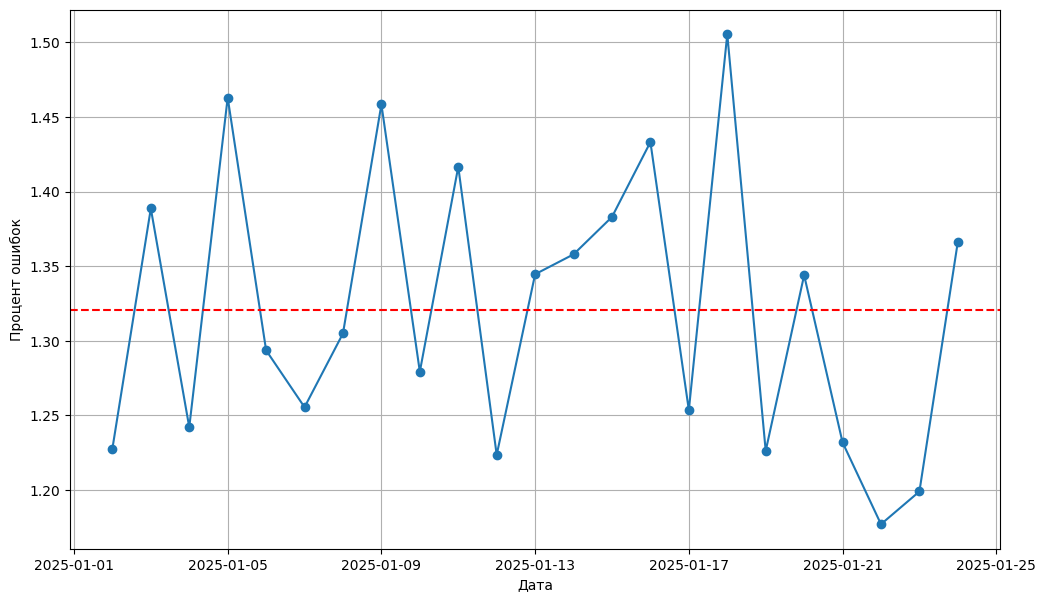

In [21]:
figsize(12, 7)

plt.plot(info_by_day['date'], info_by_day['percentage_error'], marker='o')

plt.axhline(y=mean_error, color='red', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Процент ошибок')
plt.grid()

In [22]:
df_errors['hour'] = df_errors['timestamp'].dt.hour

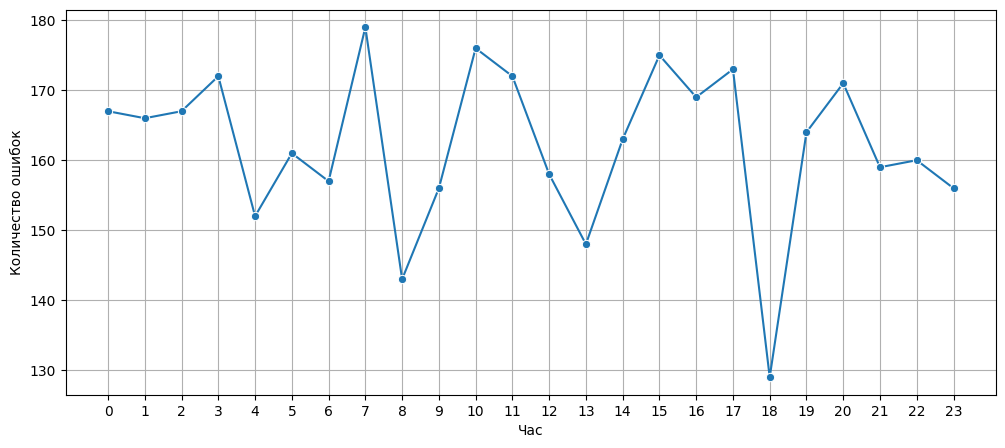

In [23]:
df_errors_grouped_hour = df_errors.groupby("hour")["user_id"].count().reset_index(name="errors")

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_errors_grouped_hour, x="hour", y="errors", marker="o")

plt.xlabel("Час")
plt.ylabel("Количество ошибок")
plt.xticks(df_errors_grouped_hour["hour"])
plt.grid()

plt.show()

Также проверим процентное соотношение

In [24]:
df['hour'] = df['timestamp'].dt.hour

In [25]:
info_by_hour = df.groupby('hour').agg({'user_id': ['count'], 'error_page': ['sum']}).reset_index()

info_by_hour.columns = ['hour', 'total', 'errors_count']

In [26]:
info_by_hour['percentage_error'] = (info_by_hour['errors_count'] / info_by_hour['total']) * 100

In [27]:
mean_error2 = info_by_hour['percentage_error'].mean()

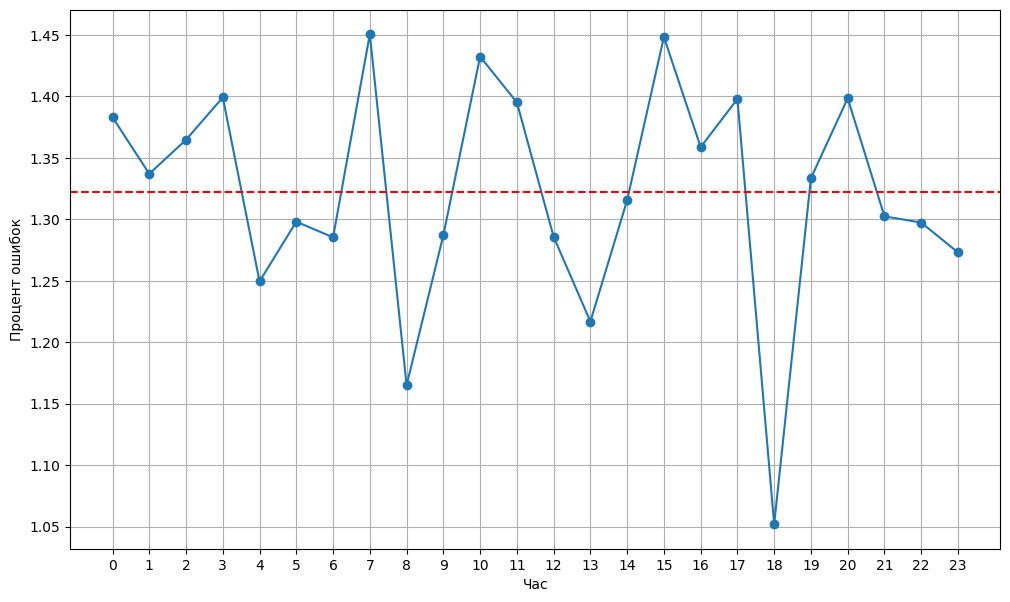

In [28]:
figsize(12, 7)

plt.plot(info_by_hour['hour'], info_by_hour['percentage_error'], marker='o')

plt.axhline(y=mean_error2, color='red', linestyle='--')

plt.xlabel('Час')
plt.ylabel('Процент ошибок')
plt.xticks(df_errors_grouped_hour["hour"])

plt.grid()










































То же самое сделаем с днями недели

In [29]:
df['day_of_week'] = df['timestamp'].dt.dayofweek

In [30]:
info_by_week = df.groupby('day_of_week').agg({'user_id': ['count'], 'error_page': ['sum']}).reset_index()

info_by_week.columns = ['day_of_week', 'total', 'errors_count']

In [31]:
info_by_week['percentage_error'] = (info_by_week['errors_count'] / info_by_hour['total']) * 100

In [32]:
mean_error3 = info_by_week['percentage_error'].mean()

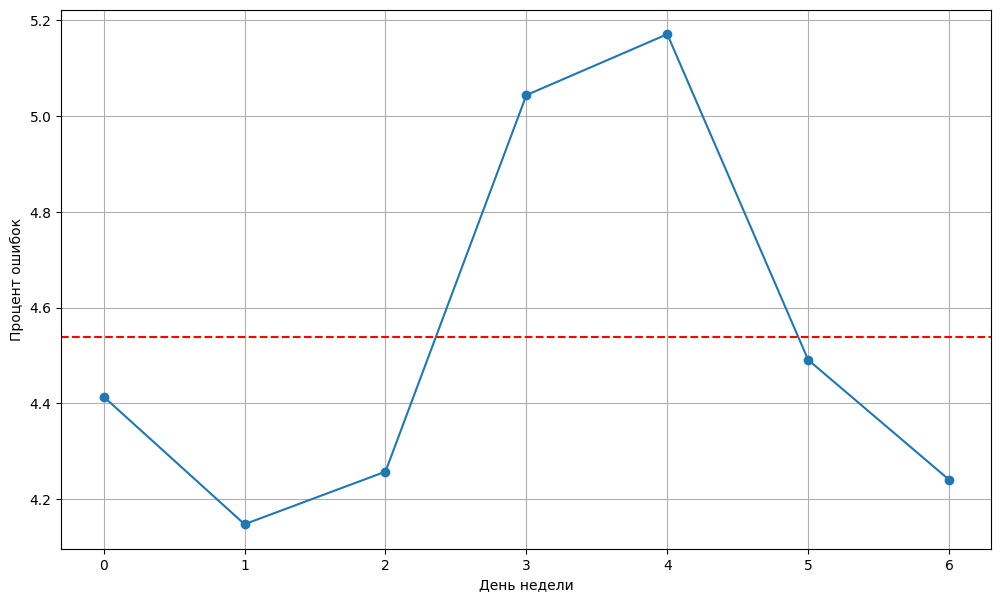

In [33]:
figsize(12, 7)

plt.plot(info_by_week['day_of_week'], info_by_week['percentage_error'], marker='o')

plt.axhline(y=mean_error3, color='red', linestyle='--')

plt.xlabel('День недели')
plt.ylabel('Процент ошибок')


plt.grid()

Итог: кажется, что ошибки появляются в рандомное время

## Один юзер в двух группах

In [34]:
df_control_users = set(df[(df['group'] == 'control') & (df['landing_page'] == 'old_page')]['user_id'].unique())
df_treatment_users = set(df[(df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]['user_id'].unique())
len(df_control_users.intersection(df_treatment_users))
# сколько правильных пользователей дублируется в обоих группах

0

In [35]:
df_control_users_errors = set(df_errors[(df_errors['group'] == 'control')]['user_id'].unique())
df_treatment_users_errors = set(df_errors[(df_errors['group'] == 'treatment')]['user_id'].unique())
len(df_control_users_errors.intersection(df_treatment_users_errors))
# сколько пользователей имеет ошибку в обоих группах

0

In [36]:
l = df.groupby(['user_id', 'group', 'landing_page']).agg({'date': ['count']})

In [37]:
l[l[('date', 'count')] > 1]

,,,date
,,,count
user_id,group,landing_page,
773192,treatment,new_page,2


есть один человек, который побывал на странице два раза, но оба раза он в правильной группе

In [38]:
df_control_users2 = set(df[(df['group'] == 'control')]['user_id'].unique())
df_treatment_users2 = set(df[(df['group'] == 'treatment')]['user_id'].unique())
len(df_control_users2.intersection(df_treatment_users2))

1895

Все дубликаты уходили в ошибки

In [39]:
s = df_control_users2.intersection(df_treatment_users2)

In [40]:
df_duplicates = pd.DataFrame()

In [41]:
for i in s:
    df_duplicates = pd.concat([df_duplicates, df[df['user_id'] == i]], axis=0)


In [42]:
df_dublicates_group = df_duplicates.groupby(['user_id', 'landing_page']).agg({'group': ['count']})

In [43]:
len(df_dublicates_group[df_dublicates_group[('group', 'count')] != 2])

0

In [44]:
time_diff = df_duplicates.groupby('user_id')['timestamp'].apply(lambda x: x.max() - x.min()).reset_index()

In [45]:
time_diff['day'] = time_diff['timestamp'].dt.total_seconds() / (24 * 3600)

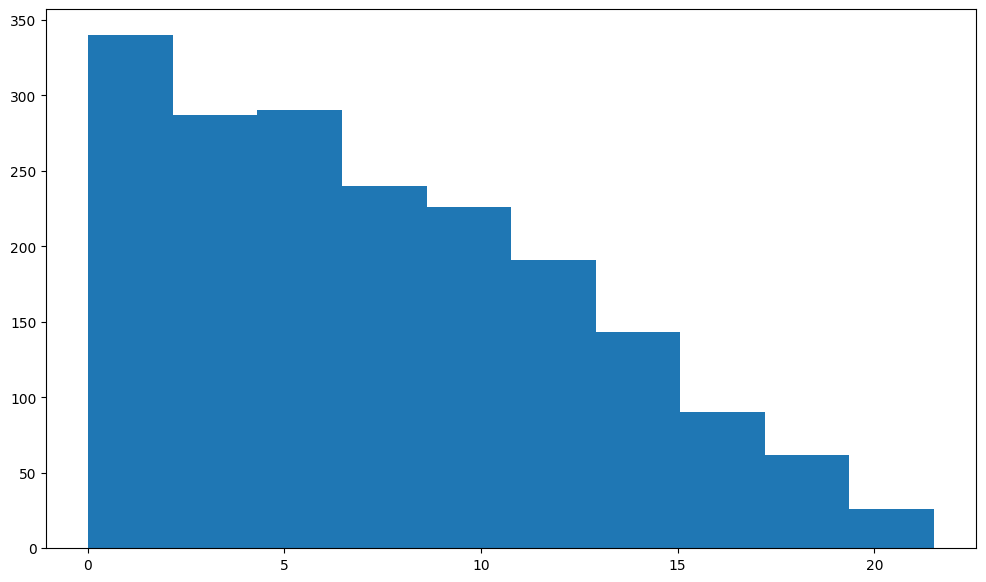

In [46]:
plt.hist(time_diff['day']);

Получается, что все дубликаты видели одну и ту же страницу, но попали в разные группы

Итог:

1. Удаляем пользователей, которые находятся не в той группе не с тобой страницей
2. Удаляем дубликаты этих неправильных пользователей
3. Удаляем оба значения пользователя, который побывал на странице дважды


Ошибка может быть как в группе, так и в странице, которая показывалась пользователю. Скорее всего проблема произошла в алгоритме разбиения или произошел сбой во время еге выполнения. Для корректного A/B теста важно, чтобы группы совпадали с показываемой страницей, а также, чтобы каждый пользователь видел страницу по одному разу (иначе его поведение может быть искажено). Поэтому все такие пользователи удаляются

In [47]:
df = df[df['error_page'] == False]

In [48]:
len(df)

290585

In [49]:
df[df['user_id']== 630052]

,user_id,timestamp,group,landing_page,converted,date,time,error_page,hour,day_of_week
230259,630052,2025-01-17 01:16:05.208766,treatment,new_page,0,2025-01-17,01:16:05,False,1,4


In [50]:
df_duplicates_delete = pd.DataFrame()

In [51]:
for i in s:
    df_duplicates_delete = pd.concat([df_duplicates_delete, df[df['user_id'] == i]], axis=0)

In [52]:
df = df.drop(df_duplicates_delete.index)

In [53]:
df = df[df['user_id'] != 773192]

In [54]:
len(df)

288688

In [55]:
df

,user_id,timestamp,group,landing_page,converted,date,time,error_page,hour,day_of_week
0,851104,2025-01-21 22:11:48.556739,control,old_page,0,2025-01-21,22:11:48,False,22,1
1,804228,2025-01-12 08:01:45.159739,control,old_page,0,2025-01-12,08:01:45,False,8,6
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0,2025-01-11,16:55:06,False,16,5
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0,2025-01-08,18:28:03,False,18,2
4,864975,2025-01-21 01:52:26.210827,control,old_page,1,2025-01-21,01:52:26,False,1,1
...,...,...,...,...,...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0,2025-01-03,22:28:38,False,22,4
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0,2025-01-12,00:51:57,False,0,6
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0,2025-01-22,11:45:03,False,11,2
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0,2025-01-15,01:20:28,False,1,2


ИТОГ:



# Часть 4. Смотрим на конверсию и преобразованный датасет

In [56]:
df['group'].value_counts()

,count
group,
treatment,144388
control,144300


In [57]:
df

,user_id,timestamp,group,landing_page,converted,date,time,error_page,hour,day_of_week
0,851104,2025-01-21 22:11:48.556739,control,old_page,0,2025-01-21,22:11:48,False,22,1
1,804228,2025-01-12 08:01:45.159739,control,old_page,0,2025-01-12,08:01:45,False,8,6
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0,2025-01-11,16:55:06,False,16,5
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0,2025-01-08,18:28:03,False,18,2
4,864975,2025-01-21 01:52:26.210827,control,old_page,1,2025-01-21,01:52:26,False,1,1
...,...,...,...,...,...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0,2025-01-03,22:28:38,False,22,4
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0,2025-01-12,00:51:57,False,0,6
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0,2025-01-22,11:45:03,False,11,2
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0,2025-01-15,01:20:28,False,1,2


In [58]:
df_convert_day = df.groupby(['date', 'group']).agg({'converted': ['mean']}).reset_index()

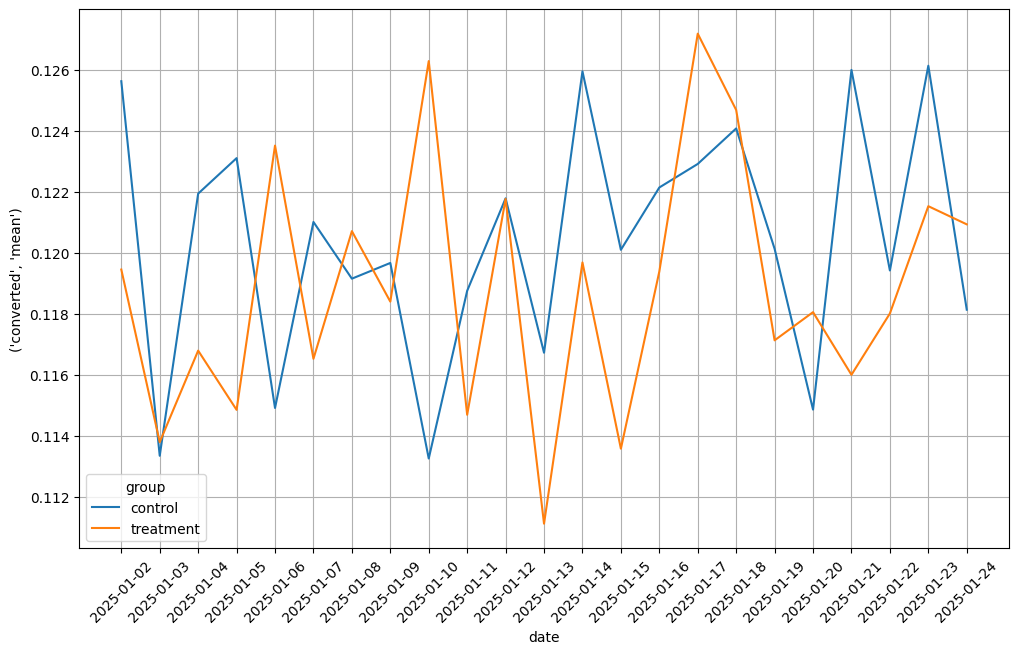

In [59]:
sns.lineplot(data=df_convert_day, x='date', y=('converted', 'mean'), hue='group')

plt.xticks(df_convert_day['date'].unique(), rotation=45)

plt.grid()

Конверсия непостоянна, но старая страница показывает болеее стабильные результаты, чем новая. Т.к. это данные за яварь возможен эффект праздников - второго января результаты высокие, т.к. покупка подарков все еще может быть актуальна, с 3-8 результаты не очень высокие т.к. в новогодние праздники спрос на образовательные платформы ниже

In [60]:
df_convert_hour = df.groupby(['hour', 'group']).agg({'converted': ['mean']}).reset_index()

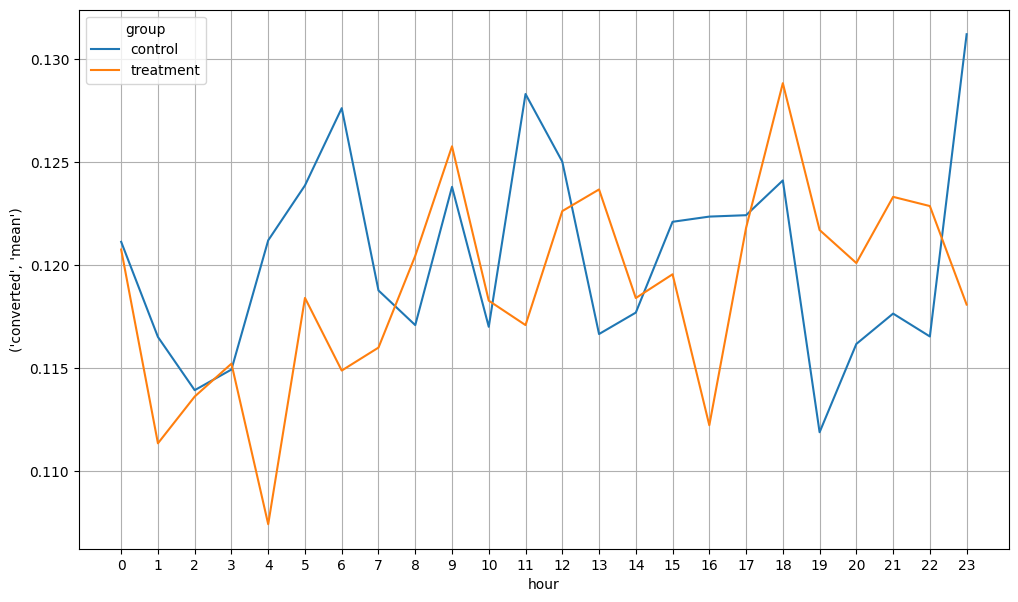

In [61]:
sns.lineplot(data=df_convert_hour, x='hour', y=('converted', 'mean'), hue='group')

plt.xticks(df_convert_hour['hour'].unique())

plt.grid()

Старая страница опять показывает более стабильые результаты. В контрольной группе наибольшие спады присходят с 19 до 22 и с 1 до 3. На новой странице спад наблюдается с 1 до 7. Этоозначает, что обе страницы хужеработают в ночное время.
Но самый высокиий пик старой страницы происходит в 23, из этого можно сделать вывод, что старая страница не слиьно зависит от времени суток

In [62]:
df_convert_dayweek = df.groupby(['day_of_week', 'group']).agg({'converted': ['mean']}).reset_index()

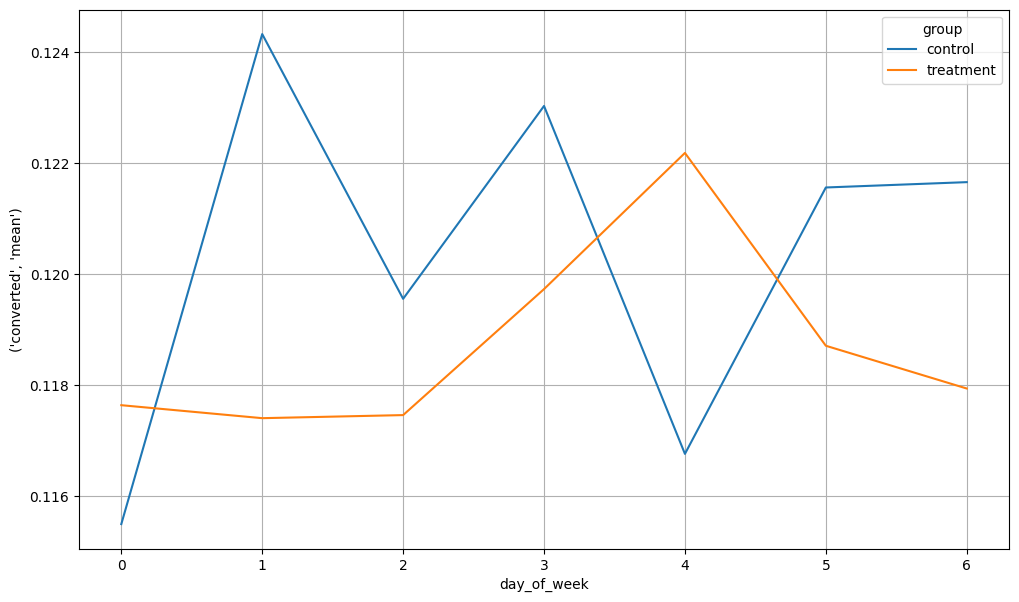

In [63]:
sns.lineplot(data=df_convert_dayweek, x='day_of_week', y=('converted', 'mean'), hue='group')

plt.xticks(df_convert_dayweek['day_of_week'].unique())

plt.grid()

Во все дни недели кроме понедельника пятницы более высокое значение у старой страницы. Это моет быть связано с тем, что новая страница кожется пользователям более актуальной перед выходными, по сравнению с будними днями.

# Часть 5. Почему нет A/A-теста и балуемся (хихикаем преимущественно)

А/А тест проводится для того, чтоб проверить, что сплит-система подбирает одинаковые группы. Для его проведения нам нужны две независимые выборки, опирающиеся на исторические данные, но у нас нет таковых, поэтому провести А/А тестирование мы не можем. А/А тестирование на наших данных проводиться не может, потому что мы не знаем что будет с метрикой, если пользователям обеих групп, на которые у нас разделены все наши пользователи, дать старую версию сайта.

(но если проводить А/А тестирование на исторических данных, то мы можем потерять новичков )

Давайте посмотрим на зависимость времени посещения страницы и группы эксперимента.

- Н0 (нулевая гипотеза) - признаки независимы и никак не влияют друг на друга
- Н1 (альтернативная гипотеза) - признаки зависят друг от друга. Между признаками есть статистически значимая связь

In [64]:
from scipy.stats import chi2_contingency

contingency_table_hour = pd.crosstab(df['hour'], df['group']) # кросс таблица нужна для того чтобы использовать хихи квадрат тест,
# потому что хихи квадрат работает только с таблицей сопряженности

chi2, p_value, dof, expected = chi2_contingency(contingency_table_hour)
# chi2 - значение статистики хи-квадрат
# p_value - p-значение теста
# dof - степень свободы
# expected - таблица ожидаемых частот

print(f'p-value: {p_value}')

p-value: 0.03045270773430462


p-value получился `0,0304`, что меньше, чем `0,05`. Значит, мы отклоняем нулевую гипотезу о том, что признаки не влияю друг на друга. Значит, есть какая-то зависимость между временем посещения страницы и группой, которая производила это посещение

In [65]:
from scipy.stats import chi2_contingency

contingency_table_week = pd.crosstab(df['day_of_week'], df['group']) # кросс таблица нужна для того чтобы использовать хихи квадрат тест,
# потому что хихи квадрат работает только с таблицей сопряженности

chi2, p_value, dof, expected = chi2_contingency(contingency_table_week)
# chi2 - значение статистики хи-квадрат
# p_value - p-значение теста
# dof - степень свободы
# expected - таблица ожидаемых частот

print(f'p-value: {p_value}')

p-value: 0.7718628553821287


p-value получился `0,77`, что больше, чем `0,05`. Значит, мы не можем отклонть нулевую гипотезу и не можем утверждать, что день недели и группы эксперемента обязательно зависят

In [66]:
from scipy.stats import chi2_contingency

contingency_table_week = pd.crosstab(df['date'], df['group']) # кросс таблица нужна для того чтобы использовать хихи квадрат тест,
# потому что хихи квадрат работает только с таблицей сопряженности

chi2, p_value, dof, expected = chi2_contingency(contingency_table_week)
# chi2 - значение статистики хи-квадрат
# p_value - p-значение теста
# dof - степень свободы
# expected - таблица ожидаемых частот

print(f'p-value: {p_value}')

p-value: 0.9285045761080558


Разделим наши данные по типу группы

In [67]:
df_control = df[df['group'] == 'control']

In [68]:
df_treatment = df[df['group'] == 'treatment']

Посмотрим на распределение данных по разным данным: часы, день недели, время, дата

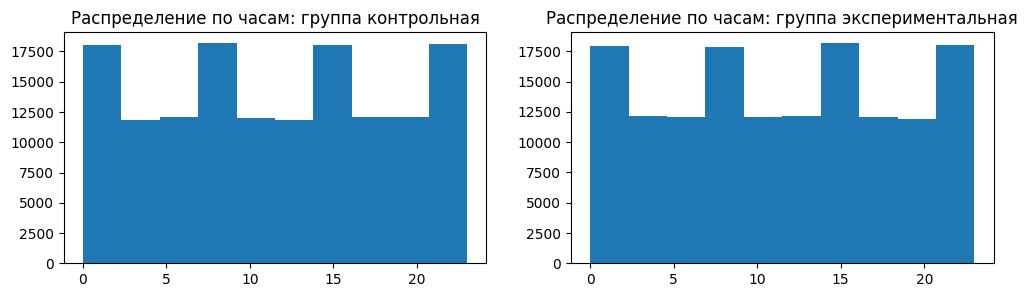

In [69]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(df_control['hour'])
plt.title('Распределение по часам: группа контрольная')

plt.subplot(1,2,2)
plt.hist(df_treatment['hour'])
plt.title('Распределение по часам: группа экспериментальная')

plt.show()

Для каждой пары распредлений проверим их схожесть через критерий Колмогорова-Смирнова: он сравнивает два распределения

- Н0 - выборки имеют одно и тоже распредление
- Н1 - выборки имеют разное распределение

In [70]:
import scipy.stats as st

In [71]:
stat_ks, p_value_ks = st.kstest(df_treatment['hour'], df_control['hour'])
print(f'статистика: {stat_ks}')
print(f'p-value: {p_value_ks}')

статистика: 0.002212222664614849
p-value: 0.8709250905734487


p-value равен `0,87` что говорит нам о том, что мы не можем опровергнуть гипотезу о том, что данные имеют олинаковое распределение

По графикам мы видим, что выборки имеют очень схожие распределения относительно часа захода на страницу

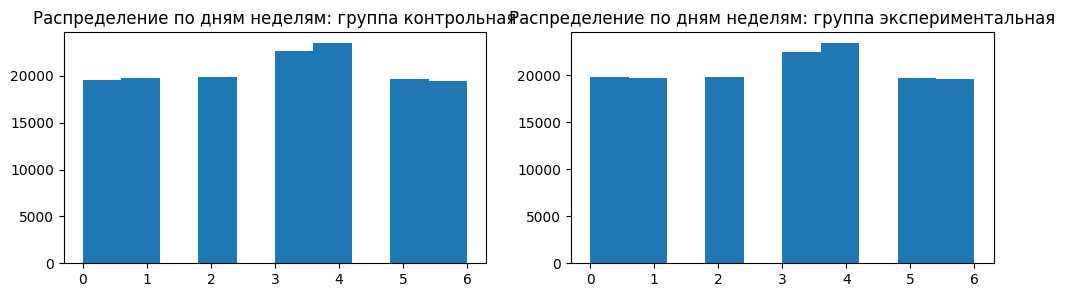

In [72]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(df_control['day_of_week'])
plt.title('Распределение по дням неделям: группа контрольная')

plt.subplot(1,2,2)
plt.hist(df_treatment['day_of_week'])
plt.title('Распределение по дням неделям: группа экспериментальная')

plt.show()

In [73]:
stat_ks, p_value_ks = st.kstest(df_treatment['day_of_week'], df_control['day_of_week'])
print(f'статистика: {stat_ks}')
print(f'p-value: {p_value_ks}')

статистика: 0.0015726185610109578
p-value: 0.9939794700480289


по дням неделям p-value равен `0,99`, что тоже нам говорит о том что мы не отрицаем гипотезу о том, что данные одинаково распределены

По графику мы можем сказать, что данные почти одинаково распределены

In [74]:
stat_ks, p_value_ks = st.kstest(df_treatment['time'], df_control['time'])
print(f'статистика: {stat_ks}')
print(f'p-value: {p_value_ks}')

статистика: 0.002740294299426682
p-value: 0.6494249315268636


тут график оч долго считается, я не дождолась его, мб даже стоит это удалить, потому что мы смотрим по часам

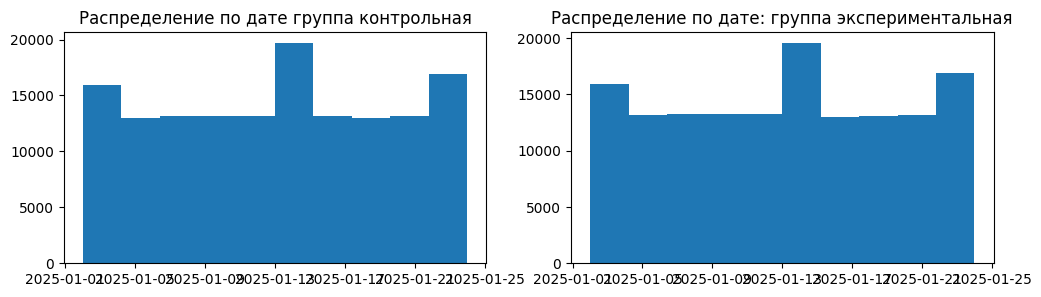

In [75]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(df_control['date'])
plt.title('Распределение по дате группа контрольная')

plt.subplot(1,2,2)
plt.hist(df_treatment['date'])
plt.title('Распределение по дате: группа экспериментальная')

plt.show()

In [76]:
stat_ks, p_value_ks = st.kstest(df_treatment['date'], df_control['date'])
print(f'статистика: {stat_ks}')
print(f'p-value: {p_value_ks}')

статистика: 0.0024884445969300395
p-value: 0.7618061161616281


по дате p-value равно `0,76` , тоже не можем опровергнуть нулевую гипотезу

По графику данные распределены почти одинаково

Итог:
- выборки по всем параметрам имеют одинаковые распределения, что говорит нам о том, что выборки являются репрезентативными
- А/В тест в данном случае объективен, потому что выборки репрезентативные

Можем переходить к А/В тестированию))

# Часть 6. A/B-тест

Нам необходимо выяснить, стоит ли внедрять новую функцию. Метрика, по которой будем оценивать успешность типа страницы - конверсия

$p_{old}$ - конверсия old_page

$p_{new}$ - конверсия new_page


$H_{0}: p_{new} = p_{old}$
, то есть, грубо говоря, конверсия на старой старанице такая же как и конверсии на новой странице


$H_{1}: p_{new} - p_{old} > 0$, то есть конверсия на новой странице выше конверсии на старой странице

Уровень значимости - 0.05

Eсли p-value (уровень значимости) меньше 0,05, то результат считается статистически значимым. Это означает, что с вероятностью 95% различия между группами не случайны, и можно утверждать, что новая версия страницы действительно лучше старой версии страницы

Проведем Z-тест

Z-тест для пропорций применяется, когда есть:

- большая выборка (n > 30) и биномиальное распредение => ИТМЛ
- нужно сравнить пропорцию выборки с известной пропорцией
- данные состоят из двух возможных исходов (сделал покупку или нет) - само биномиальное распределение

In [77]:
z_statistic, p_value = proportions_ztest(count=[(df[df['group'] == 'control']['converted'].sum()), (df[df['group'] == 'treatment']['converted'].sum())],
                                         nobs=[(len(df[df['group'] == 'control'])), (len(df[df['group'] == 'treatment']))],
                                         alternative="smaller")

In [78]:
p_value

np.float64(0.8885937135454363)

Мы не можем отвергнуть нулевую гипотезу, так как значение p_value > 0.05 (причем очень сильно)

# Часть 7. Bootstrap

Бутстрап — это вычислительный статистический метод, который позволяет оценить распределение выборочной статистики путем многократной генерации выборок методом Монте-Карло на основе уже имеющейся выборки

Проще говоря, бутстрап позволяет «притворяться» генеральной совокупностью, многократно создавая «псевдовыборки» из исходной выборки с возвращением

In [79]:
p_old = df[df['group'] == 'control']['converted'].mean()

In [80]:
p_old

np.float64(0.12030492030492031)

In [81]:
p_new = df[df['group'] == 'treatment']['converted'].mean()

In [82]:
p_new

np.float64(0.11883258996592515)

In [83]:
p_df = df['converted'].mean()

In [84]:
p_new - p_old

np.float64(-0.0014723303389951592)

In [85]:
p_df

np.float64(0.11956853073213988)

Предположим, что в соответствии с нулевой гипотезой, $p_{new}$ и $p_{old}$ имеют “истинные” показатели успешности, то есть $p_{new}$ и $p_{old}$ равны. Также предположим, что они равны показателю успешности преобразования независимо от страницы, то есть общей конверсии всего датасета

Грубо говоря, будем работать в мире, где обе версии страницы хорошие и имеют одинаковые конверсии, равные общей конверсии датасета

У нас очень маленькое различие в конверсиях по группам, такое как раз могло произойти из-за того, что у нас берутся случайные выборки, но по факту их истинная конверсия одинакова.

Итог: новая страница действительно лучше? Или наблюдаемые различия просто случайность из-за случайных выборок?

Наше предположение: $p_{new}$ = $p_{old}$ = $p_{df}$ = 0.1195685

Тогда $p_{new} - p_{old}$ = 0

In [86]:
print(f'Вероятность, что конверсия равна 1: {p_df}. Вероятность, что конверсия равна 0: {1-p_df}')

Вероятность, что конверсия равна 1: 0.11956853073213988. Вероятность, что конверсия равна 0: 0.8804314692678601


Воспользуемся методом Монте-Карло

Многократно проведем эксперименты для старой и новой страниц

1. 10000 раз сгенерируем случайную выборку для старой версии страницы с нашими вероятностями $p_{df}$ и (1 - $p_{df}$) для совершил наш пользователь действие или нет соответсвенно

2. То же самое 10000 раз сгенерируем случайную выборку для новой версии

3. Считаем разницу в долях конверсии в типах страниц


Пояснение 1 и 2 пунктов: мы создаем "псевдо"пользователей и для старой, и для новой версии страниц. Каждый пользователь с вероятностью $p_{df}$ совершает действие на странице и с вероятностью (1 - $p_{df}$) не совершает действие на странице

In [87]:
from tqdm import *
np.random.seed(15122025)

p_differences = []

for i in trange(3000):
    old_page = np.random.choice([1, 0], size=len(df[df['group'] == 'control']), p=[p_df, (1-p_df)])
    new_page = np.random.choice([1, 0], size=len(df[df['group'] == 'treatment']), p=[p_df, (1-p_df)])
    p_differences.append((new_page.mean() - old_page.mean()).mean())

100%|██████████| 3000/3000 [06:07<00:00,  8.16it/s]


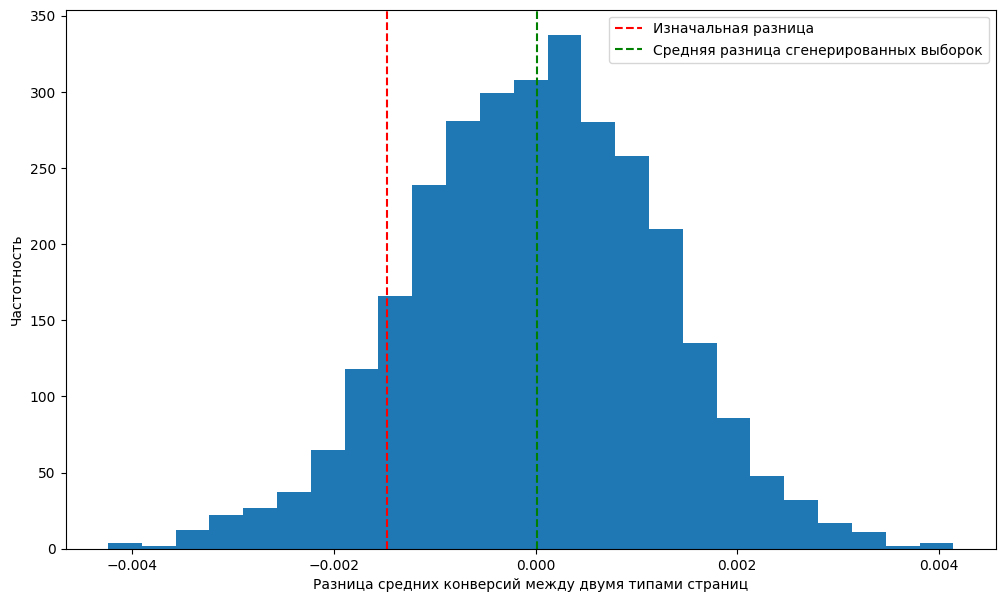

In [88]:
plt.hist(p_differences, bins=25)

plt.xlabel('Разница средних конверсий между двумя типами страниц')
plt.ylabel('Частотность')
plt.axvline(x=(p_new-p_old), color='red',linestyle='dashed', label="Изначальная разница")
plt.axvline(x=(np.array(p_differences).mean()), color='g', linestyle='dashed', label="Средняя разница сгенерированных выборок")

plt.legend()
plt.show()

Наша изначальная разница в конверсиях находится левее средней разницы сгенерированных выборок

Нужно рассчитать p_value, то есть ищем вероятность, что мы можем увидеть нашу изначальную разницу или более экстремальную, если нулевая гипотеза действительно верна

In [89]:
len([i for i in p_differences if i > (p_new - p_old)])/len(p_differences)

0.894

Получается, что мы не можем отвергнуть нулевую гипотезу, так как значение p_value > 0.05 (причем очень сильно). Получается, что конверсия на старой странице выше чем на новой, причем p_value в z-test получился примерно такой же как и в бутстрапе

In [90]:
p_differences.sort()

In [91]:
ci_2_5 = np.percentile(p_differences, 2.5)
ci_97_5 = np.percentile(p_differences, 97.5)

In [92]:
print(f'Доверительный интервал ({ci_2_5}, {ci_97_5})')

Доверительный интервал (-0.002462952770803831, 0.002414591638633801)


В доверительный интервал входит 0, поэтому нет статически значимой разницы между страницами, то есть мы не можем сделать вывод, какая хуже, лучше или они одинаковые

Итог:
- p_value > 0.05 в обоих тестах, не можем отклонить нулевую гипотезу
- Изначальная разница между средними конверсиями новой и строй страниц - отрицательная
- Три возможных реальности:

Реальность 1: Новая страница немного хуже (до -0.246%)

Реальность 2: Страницы одинаковы (разница 0%)

Реальность 3: Новая страница немного лучше (до +0.239%)

**Новую страницу не стоит внедрять**

Мы провели два основных теста.

Получается:

Z-test проверил "разные или нет" конверсии на страницах

Bootstrap оценил "насколько хуже" та или иная версия (но у нас не получилось сделать вывод из доверительного интервала)

#Часть 8. Анализ чувствительности ко времени

Основные временные рамки, которые мы можем рассмотреть:
- Дата
- Часть дня
- Выходной день или нет

In [93]:
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

Также разобьем сутки на четыре временных периода: утро, день, вечер, ночь

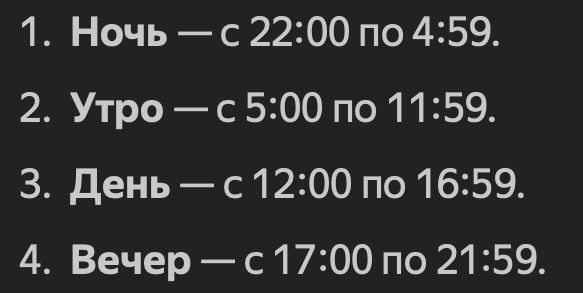

In [94]:
def time_of_day(hour):
    if 22 <= hour <= 23 or 0 <= hour <= 4:
        return 'Ночь'
    elif 5 <= hour <= 11:
        return 'Утро'
    elif 12 <= hour <= 16:
        return 'День'
    elif 17 <= hour <= 21:
        return 'Вечер'

df['period_of_day'] = df['hour'].apply(time_of_day)

In [95]:
df['period_of_day'].unique()

array(['Ночь', 'Утро', 'День', 'Вечер'], dtype=object)

Начнем с дня, в который пользователь зашел на страницу. Воспользуемся скользящим окном. Будем смотреть окно в 1, 3 и 7 дней

In [96]:
def move_window(df, window_size):
    df_days = df.groupby(['date', 'group']).agg({'converted': ['mean', 'count']}).reset_index()
    df_days.columns = ['date', 'group', 'converted_mean', 'count']

    df_days_pivot = df_days.pivot_table(index='date', columns = 'group')

    df_days_pivot['difference'] = df_days_pivot['converted_mean']['treatment'] - df_days_pivot['converted_mean']['control']
    df_days_pivot['count_total'] = df_days_pivot['count']['treatment'] + df_days_pivot['count']['control']

    # rolling - создает скользящее окно
    df_days_pivot['window_difference'] = df_days_pivot['difference'].rolling(window=window_size, center=True).mean()
    df_days_pivot['window_std'] = df_days_pivot['difference'].rolling(window=window_size, center=True).std()

    df_days_pivot['lower'] = df_days_pivot['window_difference'] - 1.96 * df_days_pivot['window_std'] / np.sqrt(window_size)
    df_days_pivot['upper'] = df_days_pivot['window_difference'] + 1.96 * df_days_pivot['window_std'] / np.sqrt(window_size)

    return df_days_pivot

In [97]:
windows = [1, 3, 7]
window_rsults = {}

for i in windows:
    window_rsults[i] = move_window(df, i)

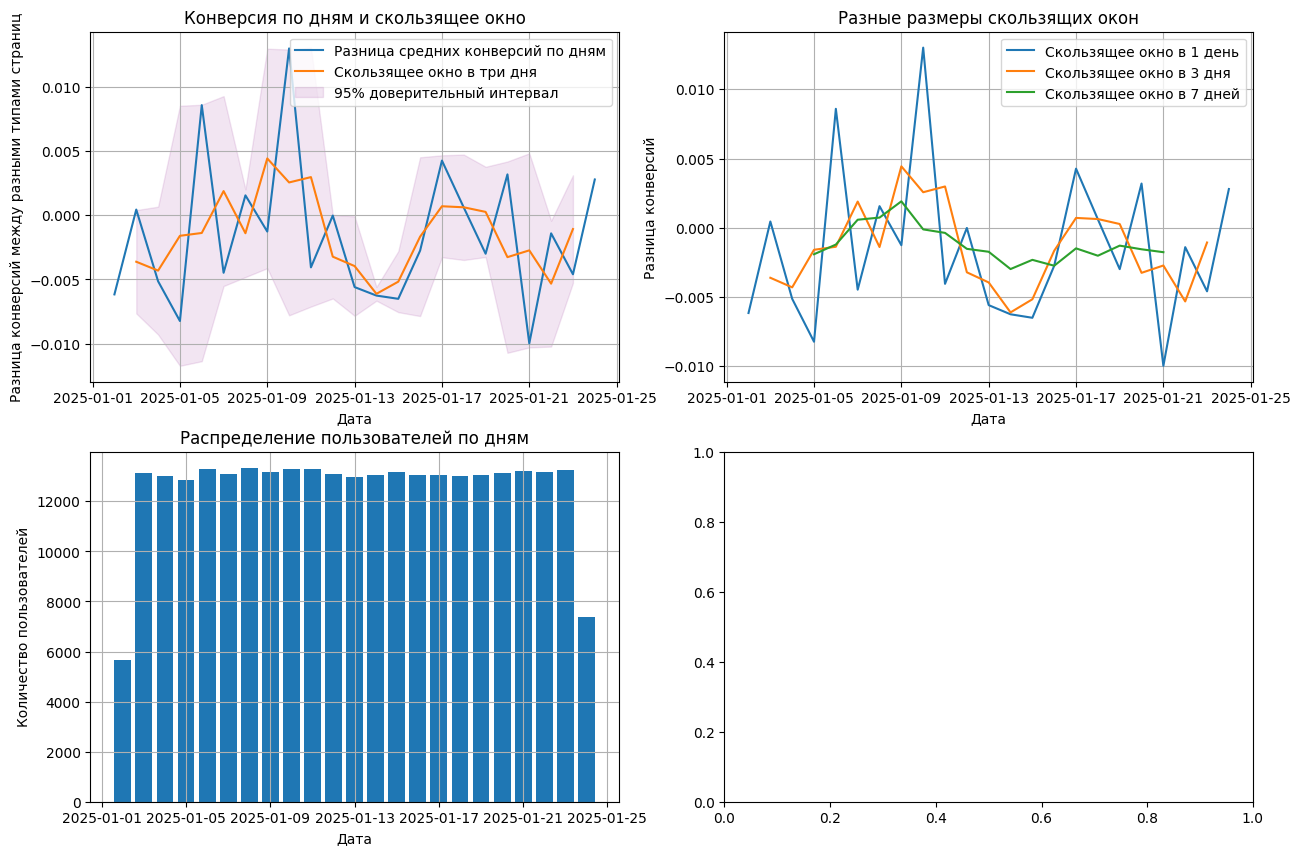

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(window_rsults[1].index, window_rsults[1]['window_difference'], label='Разница средних конверсий по дням')
axes[0, 0].plot(window_rsults[3].index, window_rsults[3]['window_difference'], label='Скользящее окно в три дня')
axes[0, 0].fill_between(window_rsults[3].index, window_rsults[3]['lower'], window_rsults[3]['upper'], label='95% доверительный интервал', alpha=0.1, color='purple')

axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Разница конверсий между разными типами страниц')
axes[0, 0].legend()
axes[0, 0].set_title('Конверсия по дням и скользящее окно')
axes[0, 0].grid()

axes[0, 1].plot(window_rsults[1].index, window_rsults[1]['difference'], label='Скользящее окно в 1 день')
axes[0, 1].plot(window_rsults[3].index, window_rsults[3]['window_difference'], label='Скользящее окно в 3 дня')
axes[0, 1].plot(window_rsults[7].index, window_rsults[7]['window_difference'], label='Скользящее окно в 7 дней')

axes[0, 1].set_xlabel('Дата')
axes[0, 1].set_ylabel('Разница конверсий')
axes[0, 1].legend()
axes[0, 1].set_title('Разные размеры скользящих окон')
axes[0, 1].grid()

axes[1, 0].bar(window_rsults[3].index, window_rsults[3]['count_total'])

axes[1, 0].set_xlabel('Дата')
axes[1, 0].set_ylabel('Количество пользователей')
axes[1, 0].set_title('Распределение пользователей по дням')
axes[1, 0].grid()


plt.show()

В целом пользователи довольно равномерно распределены по дням (кроме первого и последнего дня).

**Рассмотрим скользящее окно в один день:**

Колебание конверсий от -0.009983 до 0.013015

Четких вывод по конверсиям со скользящим окном в один день мы особо сделать не можем

**Далее рассмотрим скользящее окно в три дня:**

Видим, что уже нет ярко выраженных пиков, отрицательная конверсия преобладает

**Рассмотрим скользящее окно в 7 дней:**

Еще больше отрицательных трендов. После 10 января конверсия была только отрицательной. Получается, что в долгосрочной перспективе новая страница работает на пользователя хуже чем старая



---

Далее проведем анализ по времени суток. Рассмотрим четыре временных рамки, на которые мы делали ранее: утро, день, вечер, ночь

Для каждой из частей дней будем проводить z-test.

Для каждой из частей дня у нас будет нулевая и альтернативная гипотезы

$p_{old}$ - конверсия old_page

$p_{new}$ - конверсия new_page


$H_{0} - p_{new} = p_{old}$
конверсия на старой старнице такая же как и конверсии на новой странице в эту временную часть дня


$H_{1} - p_{new} - p_{old} > 0$, то есть конверсия на новой странице выше конверсии на старой странице в эту временную часть дня

Уровень значимости - 0.05



In [99]:
df.head(2)

,user_id,timestamp,group,landing_page,converted,date,time,error_page,hour,day_of_week,weekend,period_of_day
0,851104,2025-01-21 22:11:48.556739,control,old_page,0,2025-01-21,22:11:48,False,22,1,0,Ночь
1,804228,2025-01-12 08:01:45.159739,control,old_page,0,2025-01-12,08:01:45,False,8,6,1,Утро


In [100]:
result_time_period = []

In [101]:
for j in ['Утро', "День", "Вечер", "Ночь"]:
    data = df[df['period_of_day'] == j]

    data_c = data[data['group'] == 'control']
    data_t = data[data['group'] == 'treatment']

    z_statistic, p_value = proportions_ztest(count=[(data[data['group'] == 'control']['converted'].sum()), (data[data['group'] == 'treatment']['converted'].sum())],
                                         nobs=[(len(data[data['group'] == 'control'])), (len(data[data['group'] == 'treatment']))],
                                         alternative="smaller")

    p_old = data_c['converted'].mean()
    p_new = data_t['converted'].mean()
    difference = p_new - p_old

    result_time_period.append((j, difference, p_value, p_value < 0.05))

In [102]:
columns_names = ['Часть суток', 'Разница', 'p_value', 'p_value < 0.05']
df_time_period = pd.DataFrame(result_time_period, columns=columns_names)

In [103]:
df_time_period

,Часть суток,Разница,p_value,p_value < 0.05
0,Утро,-0.003664,0.948839,False
1,День,-0.001463,0.709574,False
2,Вечер,0.004732,0.037486,True
3,Ночь,-0.003711,0.952704,False


In [104]:
result_weekend = []

In [105]:
for j in range(2):
    data = df[df['weekend'] == j]

    data_c = data[data['group'] == 'control']
    data_t = data[data['group'] == 'treatment']

    z_statistic, p_value = proportions_ztest(count=[(data[data['group'] == 'control']['converted'].sum()), (data[data['group'] == 'treatment']['converted'].sum())],
                                         nobs=[(len(data[data['group'] == 'control'])), (len(data[data['group'] == 'treatment']))],
                                         alternative="smaller")

    p_old = data_c['converted'].mean()
    p_new = data_t['converted'].mean()
    difference = p_new - p_old

    result_weekend.append((j, difference, p_value, p_value < 0.05))

In [106]:
columns_names = ['Выходной', 'Разница', 'p_value', 'p_value < 0.05']
df_weekend = pd.DataFrame(result_weekend, columns=columns_names)

In [107]:
df_weekend

,Выходной,Разница,p_value,p_value < 0.05
0,0,-0.000800,0.714241,False
1,1,-0.003282,0.921179,False


In [133]:
result_holidays = []

In [134]:
holidays = ['2025-01-02', '2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08']

holidays_set = set(holidays)
df['holidays'] = np.where((df['weekend'] == 1) | (df['date'].astype(str).isin(holidays_set)), 1, 0)

In [135]:
for j in range(2):
    data = df[df['holidays'] == j]

    data_c = data[data['group'] == 'control']
    data_t = data[data['group'] == 'treatment']

    z_statistic, p_value = proportions_ztest(count=[(data[data['group'] == 'control']['converted'].sum()), (data[data['group'] == 'treatment']['converted'].sum())],
                                         nobs=[(len(data[data['group'] == 'control'])), (len(data[data['group'] == 'treatment']))],
                                         alternative="smaller")

    p_old = data_c['converted'].mean()
    p_new = data_t['converted'].mean()
    difference = p_new - p_old

    result_holidays.append((j, difference, p_value, p_value < 0.05))

In [136]:
columns_names = ['Праздники', 'Разница', 'p_value', 'p_value < 0.05']
df_holidays = pd.DataFrame(result_holidays, columns=columns_names)

In [137]:
df_holidays

,Праздники,Разница,p_value,p_value < 0.05
0,0,-0.001413,0.801693,False
1,1,-0.001535,0.809474,False


# Часть 9. Байесовский A/B тест

**Идея данной штуки:** мы работаем с распределением вероятности параметров после учета новых данных, а не рассматриваем одну гипотезу. То есть мы выражаем свои предположения на основе фактических наблюдений, а не через p-value

* Много информации брала из блокнота: https://github.com/dakhakimova/YSDA_ABweek/blob/main/AB%20Week.%20Day%205.ipynb

Как происходит сравнение групп

- считаем апростериорные распределения
- будем считать вероятность того, что конверсия в группе Treatment больше, чем в группе Control



Для конверсиия чаще всего для априорного разпределния берется Бета-распределение

(Априорное распределение вероятностей — это распределение, которое используется для описания предварительных знаний о параметрах модели до того, как были получены данные. Оно используется в Байесовской статистике и позволяет оценить неизвестные параметры модели на основе данных и предварительных знаний.)


априорное распределение — это формализация наших предварительных предположений, которая гибко подстраивается под новые данные в рамках байесовского подхода к статистическому моделированию.

этапы:
1. априорное распределение: бета-распредление: `Beta($\alpha$, $\beta$)
 - $\alpha$ кол-во конверсий равна 1
 - $\beta$ кол-во конверсий равна 0

Для конверсия обычно используют это распределение `Beta(1, 1)`. (https://habr.com/ru/companies/glowbyte/articles/732024/ в шадовском курсе тоже такое). Это означает, что значение конверсии 1 или 0 равнвероятно

2. Считаем сколько `convercted` равны 1 по каждой группе и считаем конверсии по каждой группе

3. Обновляем данные априорного распределения до апостериорного

(Для бета-распределения и биномиальных данных)
- априор был у нас `Beta(1, 1)`
- данные значение `convercted` равно 1 и 0
- апостериор: `Beta(1 + кол-во 1 в convercted, 1 + кол-во 0 в convercted)`


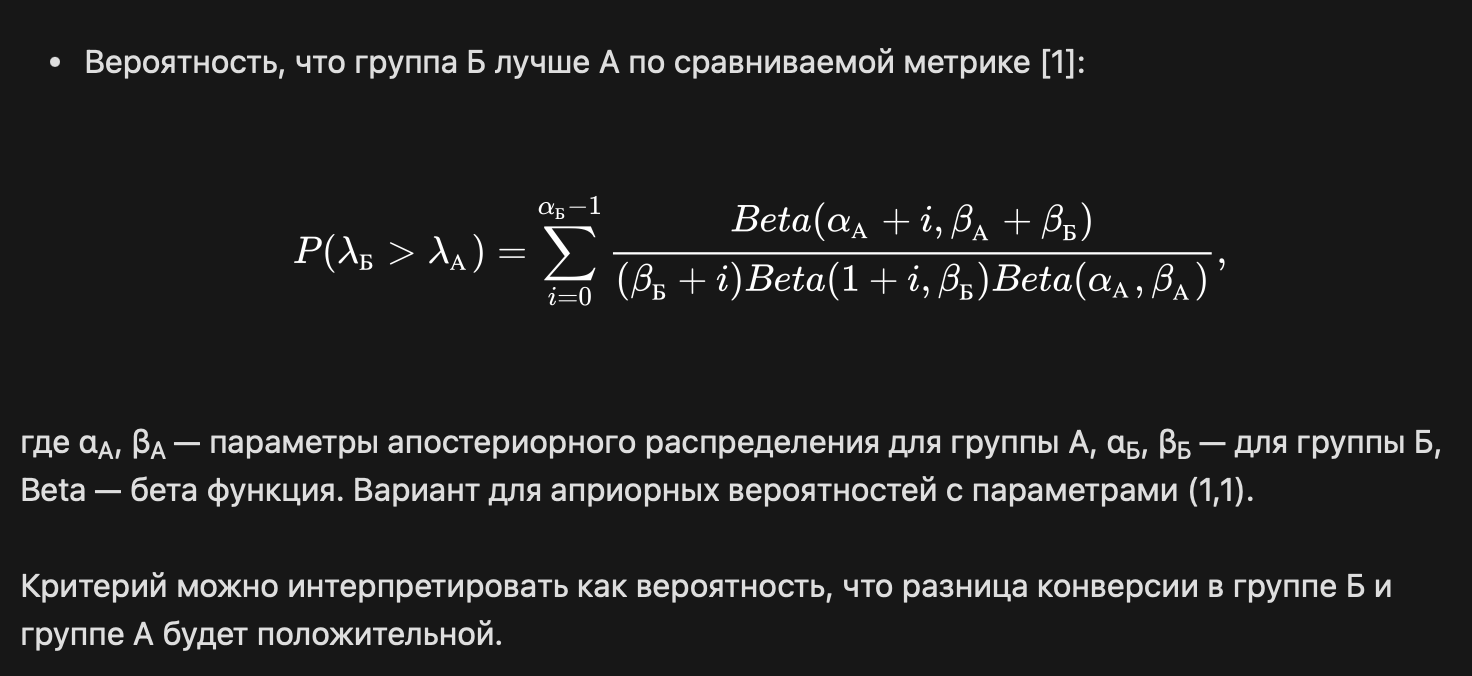

In [109]:
conversion_control = np.mean(df_control['converted'].values)
conversion_treatment = np.mean(df_treatment['converted'].values)

print(f'Конверсия контрольной группы: {conversion_control:.4f}')
print(f'Конверсия экспериментальной группы: {conversion_treatment:.4f}')

Конверсия контрольной группы: 0.1203
Конверсия экспериментальной группы: 0.1188


конверсия у группы Control выше,чем у Treatment откуда можно сделать уже вывожя, что Treatment не лучше Control

In [110]:
from scipy.special import betaln

def posteriors(df_control, df_treatment):
  df_control = df_control['converted']
  df_treatment = df_treatment['converted']
  good_control = np.sum(df_control)
  good_treatment = np.sum(df_treatment)

  bad_control = len(df_control) - good_control
  bad_treatment = len(df_treatment) - good_treatment

  # Апостериорные параметры (простое сложение)
  post_alpha_control = 1 + good_control
  post_beta_control = 1 + bad_control

  post_alpha_treatment = 1 + good_treatment
  post_beta_treatment = 1 + bad_treatment

  return post_alpha_control, post_beta_control, post_alpha_treatment, post_beta_treatment

4. Сравниваем наши распределения через симуляцию. То есть мы генерируем много случайных выборок (мы генерируем 100000 выборок) из каждого апостериорного распределения

5. Считаем вероятность, что Treatment лучше Control: среднее значение от количества когда samples_treatment > samples_control ( функция `mean` преоразует True в 1, а Flse в 0)

То есть считаем долю сэмплов где Treatment лучше Control


In [111]:
def bayes_prob_B_superior(df_control, df_treatment):
  post_alpha_control, post_beta_control, post_alpha_treatment, post_beta_treatment = posteriors(df_control, df_treatment)

  # Вероятность того, что Treatment лучше Control через симуляцию: она наглядная и гибкая
  # Также можно вероятность посчитать аналитически (интегрированием) - бе, такое не хочется

  N = 100000
  samples_control = np.random.beta(post_alpha_control, post_beta_control, N)
  samples_treatment = np.random.beta(post_alpha_treatment, post_beta_treatment, N)

  prob_treatment = np.mean(samples_treatment > samples_control) #вероятность того, что конверсия Treatment лучше Control

  return prob_treatment

выводим результат: с какой вероятностью treatment превосходит Control

In [112]:
result = bayes_prob_B_superior(df_control, df_treatment)
print(f'Вероятность превосходства Treatment над Control: {result:.4f}')

Вероятность превосходства Treatment над Control: 0.1113


проверим, что симуляция надежна и устойчива. Будем вызывать ее 500 раз

In [113]:
def simulate_tests(df_control, df_treatment, n_sims):

    bayes_probs = []

    for _ in range(n_sims):
      prob = bayes_prob_B_superior(df_control, df_treatment)
      bayes_probs.append(prob)

    return bayes_probs

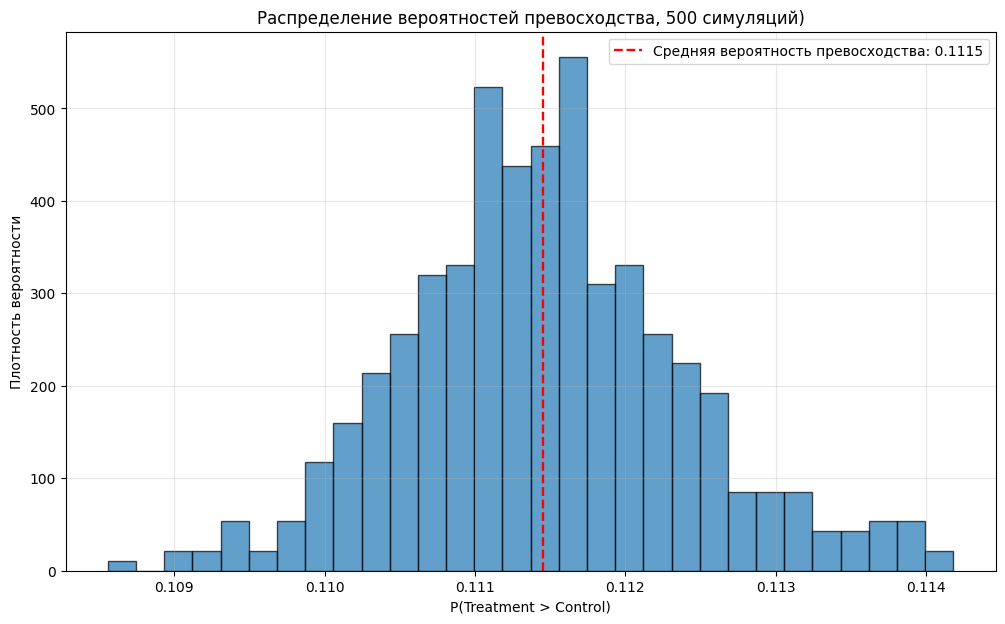

In [114]:
bayes_probs = simulate_tests(df_control, df_treatment, 500)
plt.hist(bayes_probs, bins=30, alpha=0.7, edgecolor='black', density=True)
plt.axvline(np.mean(bayes_probs), color='red', linestyle='--', linewidth=1.7,
                label=f'Средняя вероятность превосходства: {np.mean(bayes_probs):.4f}')
plt.xlabel('P(Treatment > Control)')
plt.ylabel('Плотность вероятности')
plt.title(f'Распределение вероятностей превосходства, 500 симуляций)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

получается, что вероятность превосходства имеет среднее значение `0.1113`, что отличается от нашей итоговой вероятности на совсем небольшое количество

Итог: мы получили вероятность, что Treatment лучше Control всего 11-12%. процент превосходства довольно таки мал, что говорит нам о том, что новая версия нелучше старой. Стоит прекратить тестирование и отказаться от этой новой версии сайта